In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *
from aodfunctions.outofplane import *
# from aodfunctions.outofplane import *
from scipy.ndimage import zoom

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


# Set default plotting style
plt.style.use('seaborn-whitegrid')

# Set rcParams for scientific plotting
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    'figure.figsize': (10, 6),      # Default figure size
    'axes.titlesize': 16,           # Title font size
    'axes.labelsize': 14,           # Axes labels font size
    'lines.linewidth': 2,           # Line width
    'lines.markersize': 6,          # Marker size
    'xtick.labelsize': 12,          # X-tick labels font size
    'ytick.labelsize': 12,          # Y-tick labels font size
    'legend.fontsize': 12,          # Legend font size
    'font.family': 'serif',         # Font family
    'font.serif': ['Times New Roman'],
    'grid.alpha': 0.7,              # Grid transparency
    'grid.linestyle': '--',         # Grid line style
    'axes.grid': True,              # Show grid
    'savefig.dpi': 300,             # Save figure resolution
    'savefig.format': 'png'         # Default save format
})

import diffractsim
diffractsim.set_backend("CUDA") #Change the string to "CUDA" to use GPU acceleration

from diffractsim import MonochromaticField, Lens, nm, mm, cm, RectangularSlit


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 120*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -20*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 20*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth =2*cp.pi*20*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34) /(2*cp.pi)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)
def micronstoMHz(startlocation_microns, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    frequencyposition_meters = startlocation_microns
    frequencyposition_pixel = positionstofourier(frequencyposition_meters,0, globalvariables)[0]
    acousticwavelength_pixel = (numpix_real)/(frequencyposition_pixel - numpix_real // 2)
    acousticwavelength_meters = acousticwavelength_pixel * pixelsize_real
    frequencyposition_MHz = soundvelocity / acousticwavelength_meters
    return frequencyposition_MHz   
print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")
print(len(AWGwaveform))


numzframes = 30
zstart = focallength-5e-6
frame_zspacing = 1e-6
frame_size = [10e-6, 10e-6]
frameheight_real = 49

oop_variables = [numzframes, zstart, frame_zspacing, frame_size, frameheight_real]
numzframes, zstart, frame_zspacing, frame_size, frameheight_real = oop_variables


Tweezer starting positions: -20.0 microns or -2.267573696145124 MHz
Tweezer ending positions: 20.0 microns or 2.267573696145124 MHz
One micron corresponds to 0.1133786848072586 MHz
6200


In [4]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp_general(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position_microns, expanded_time = expand_position_array(time, optimized_position, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_velocity, expanded_time = expand_position_array(time, optimized_velocity, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
# init_forces = retrieveforces(AWGinitguessexponential, globalvariables, 10, True)
# init_potentials = retrievepotentials(AWGinitguessexponential, globalvariables, 10, True)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 1.5784681295372138e-07


In [5]:
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
numzframes, zstart, frame_zspacing, frame_size, frameheight_real = oop_variables
frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
startposition_x = frame_size[0] / frame_xspacing
finalposition_x = (frame_size[0]  + cp.abs(startlocation - endlocation)) / frame_xspacing # In units of FRAME pixels
finalposition_z = (focallength - zstart) / frame_zspacing
finalposition = [finalposition_x, finalposition_z]

# Calibration for frame by frame
tweezerenergy_max = hbar * tweezerdepth
potential = snapshots_oop_potential(AWGinitguessexponential[0:500], tweezerenergy_max, numzframes, zstart, frame_zspacing, frameheight_real, frame_size, globalvariables)

potential_slices, zz, xx = interpolate_potential_cp(potential, frame_xspacing, frame_zspacing)
# Compute gradient
grad_x, grad_z = compute_gradient_cp(potential_slices, frame_xspacing, frame_zspacing)
forces = cp.array([grad_x, grad_z]) 

extendedpositionramp = cp.zeros(len(AWGinitguessexponential))
extendedpositionramp[numpix_frame:-numpix_frame] = tocupy(expanded_position_microns)
extendedpositionramp[0:numpix_frame] = expanded_position_microns[0]
extendedpositionramp[-numpix_frame:] = (expanded_position_microns[-1])
extendedpositionramp = (extendedpositionramp + frame_size[0] + cp.abs(cp.min(extendedpositionramp))) / frame_xspacing


In [65]:
extendedpositionramp[250]

array(83.33333333)

In [62]:
velocityramp = np.gradient(tonumpy(expanded_position_microns), edge_order=2) / timestep
extendedvelocityramp = np.zeros(len(AWGinitguessexponential))
extendedvelocityramp[numpix_frame:-numpix_frame] = velocityramp
extendedvelocityramp[0:numpix_frame] = velocityramp[0]
extendedvelocityramp[-numpix_frame:] = (velocityramp[-1])


In [66]:
extendedvelocityramp[250]

0.0008234480008556353

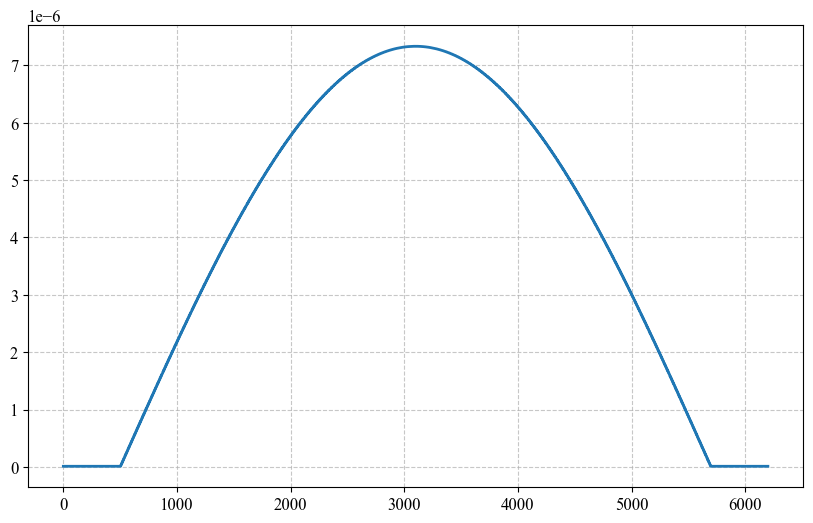

In [64]:
C = focallength**2 * wavelength / (2*np.pi * soundvelocity**2) * 2*np.pi
microntoMHZfactor = micronstoMHz(extendedvelocityramp[len(extendedvelocityramp)//2], globalvariables) / extendedvelocityramp[len(extendedvelocityramp)//2]

plt.plot(C * microntoMHZfactor * extendedvelocityramp)
plt.show()

In [69]:
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max


def analyze_waveformV2(AWGwaveform,positionramp_microns, temperature, globalvariables, oop_variables, timeperframe = 1, numframes = 1000):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    numzframes, zstart, frame_zspacing, frame_size, frameheight_real = oop_variables
    kb = 1.38*10**(-23)

    # Calibration for frame by frame
    tweezerenergy_max = hbar * tweezerdepth * 10
    calibrationshot = snapshots_oop_potential(AWGwaveform[0:500], 1, 1, focallength, 0,
                                  frameheight_real, frame_size, globalvariables)
    calibrationshot_max = cp.max(calibrationshot)
    normalizedenergy = tweezerenergy_max / calibrationshot_max
    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)

    # For final position of tweezer
    frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
    startposition_x = frame_size[0] / frame_xspacing
    finalposition_x = (frame_size[0]  + cp.abs(startlocation - endlocation)) / frame_xspacing # In units of FRAME pixels
    finalposition_z = (focallength - zstart) / frame_zspacing
    finalposition = [finalposition_x, finalposition_z]

    # Initialize atomic distribution and tweezer width
    calibration_potential = snapshots_oop_potential(AWGwaveform[-numpix_frame:], 1, numzframes, zstart, frame_zspacing, 
                                                    frameheight_real, frame_size, globalvariables)
    tweezerwidths = fit_gaussian_2d(tonumpy(calibration_potential))
    initdistribution = initdistribution_MaxwellBoltzmann3DV2(potential, num_particles, temperature, zstart, frame_zspacing, frame_size, globalvariables,oop_variables)

    def wrapper(waveformshot):
        potential = snapshots_oop_potential(waveformshot, normalizedenergy, numzframes, zstart, frame_zspacing, frameheight_real, frame_size, globalvariables)
        potential_slices, zz, xx = interpolate_potential_cp(potential, frame_xspacing, frame_zspacing)
        # Compute gradient
        grad_x, grad_z = compute_gradient_cp(potential_slices, frame_xspacing, frame_zspacing)
        forces = cp.array([grad_x, grad_z]) 
        return forces

    #### Propagate atomic time evolution
    
    positionramp = cp.zeros(len(AWGinitguessexponential))
    positionramp[numpix_frame:-numpix_frame] = tocupy(positionramp_microns)
    positionramp[0:numpix_frame] = positionramp_microns[0]
    positionramp[-numpix_frame:] = (positionramp_microns[-1])
    positionramp = (positionramp + frame_size[0] + cp.abs(cp.min(positionramp))) / frame_xspacing

    velocityramptemp = np.gradient(tonumpy(positionramp_microns), edge_order=2) / timestep
    velocityramp = np.zeros(len(AWGinitguessexponential))
    velocityramp[numpix_frame:-numpix_frame] = velocityramptemp
    velocityramp[0:numpix_frame] = velocityramptemp[0]
    velocityramp[-numpix_frame:] = (velocityramptemp[-1])
    # print(len(snapshots))
    # print(initdistribution)
    # print(x0[0])
    # print(z0[0])


    x0 = tocupy(initdistribution[0][:,0]) # Right now its in FRAME pixels
    dx0 = tocupy(initdistribution[1][:,0]) # Right now its in m/s
    z0 = tocupy(initdistribution[0][:,1]) # Right now its in FRAME pixels
    dz0 = tocupy(initdistribution[1][:,1]) # Right now its in m/s
    x_t1 = x0
    dx_t1 = dx0
    z_t1 = z0
    dz_t1 = dz0

    time = 0
    atomcoordinates = []
    atomcoordinates.append([x_t1, z_t1])
    relativecoordinates = []
    x_t1_rel, z_t1_rel = x_t1 - positionramp[numpix_frame // 2], z_t1 - velocityramp[numpix_frame // 2]
    relativecoordinates.append([x_t1_rel, z_t1_rel])

    atomtemperatures = []
    temperatureframe = atommass * (dx0**2+dz0**2) / kb
    atomtemperatures.append(temperatureframe)

    atomforceprofiles = []
    force1 = wrapper(snapshots[0])
    force2 = wrapper(snapshots[1])
    atomforceprofiles.append(force1)

    iterationsteps = (len(AWGwaveform) - numpix_frame) +1
    snapshotsindices = np.linspace(0, iterationsteps - 1, len(snapshots), dtype=int)
    current_M_index = 1
    framespacing = iterationsteps // numframes
    
    for iteration in range(iterationsteps):
        time += timestep
        if iteration == snapshotsindices[current_M_index]:
            force1 = force2
            if current_M_index + 1 < len(snapshots):
                force2 =  wrapper(snapshots[current_M_index+1])
                current_M_index += 1    
        else:
            t = (iteration - snapshotsindices[current_M_index - 1]) / (snapshotsindices[current_M_index] - snapshotsindices[current_M_index - 1])
            interpolated_force = [
                (1 - t) * force1[0] + t * force2[0],
                (1 - t) * force1[1] + t * force2[1]
            ]


        ddx_frame = interpolated_force[0] / atommass # gradient in terms of m/s^2 now, with coordinates 1 pixel -> frame_xspacing 
        ddz_frame = interpolated_force[1] / atommass # gradient in terms of m/s^2 now, with coordinates 1 pixel -> zspacing

        ddx_t1,ddz_t1 = interpolate_gradient_cp(ddx_frame, ddz_frame, x_t1, z_t1) # in units of m/s^2 
        dx_t2 = dx_t1 + ddx_t1 * timestep # in units of m/s
        x_t2 = x_t1 + dx_t1 * timestep / frame_xspacing  # in units of FRAME pixels
        dz_t2 = dz_t1 + ddz_t1 * timestep
        z_t2 = z_t1 + dz_t1 * timestep / frame_xspacing
        dx_t1 = dx_t2
        x_t1 = x_t2
        dz_t1 = dz_t2
        z_t1 = z_t2
        if iteration % framespacing == 0:
            temperatureframe = atommass * (dx0**2+dz0**2) / kb
            x_t1_rel, z_t1_rel = x_t1 - positionramp[numpix_frame // 2 + iteration], z_t1 - velocityramp[numpix_frame // 2 + iteration]
            
            atomcoordinates.append([x_t1, z_t1])
            relativecoordinates.append([x_t1_rel, z_t1_rel])
            atomtemperatures.append(temperatureframe)
            atomforceprofiles.append(force1)


    position_out = np.array([tonumpy(x_t1),tonumpy(z_t1)])
    velocity_out = np.array([tonumpy(dx_t1),tonumpy(dz_t1)])


    survivalprobability = analyze_survivalprobability_oop_2D(position_out, finalposition, tweezerwidths, globalvariables)

    # Store the result in the results array

    return survivalprobability, cp.array(atomcoordinates), cp.array(relativecoordinates), cp.array(atomtemperatures), cp.array(atomforceprofiles)

survivalprobability, atomcoordinates, relativecoordinates, atomtemperatures, atomforceprofiles = analyze_waveformV2(AWGinitguessexponential,expanded_position_microns, 1e-6, globalvariables, oop_variables, 10,100)

   



In [76]:
np.save('survivalprobability.npy', survivalprobability)
np.save('atomcoordinates.npy', atomcoordinates)
np.save('relativecoordinates.npy', relativecoordinates)
np.save('atomtemperatures.npy', atomtemperatures)
np.save('atomforceprofiles.npy', atomforceprofiles)

In [77]:
survivalprobability_restored = np.load('survivalprobability.npy')
atomcoordinates_restored = np.load('atomcoordinates.npy')
relativecoordinates_restored = np.load('relativecoordinates.npy')
atomtemperatures_restored = np.load('atomtemperatures.npy')
atomforceprofiles_restored = np.load('atomforceprofiles.npy')

No handles with labels found to put in legend.


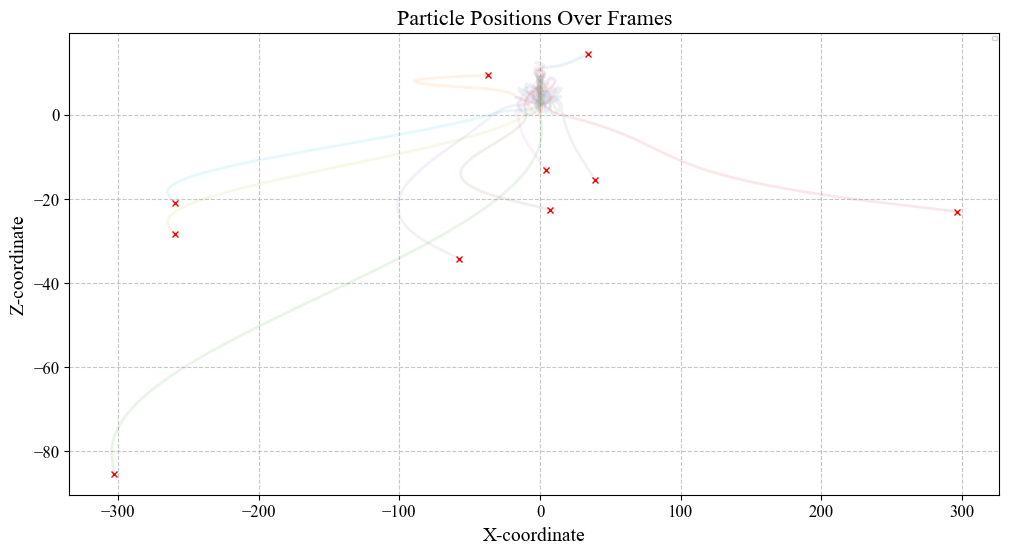

In [74]:
def plot_particle_positions_singleshot(movementframes, samples=10):
    # Convert CuPy array to NumPy array for plotting
    movementframes = tonumpy(movementframes)
    framecount, _, numparticles = movementframes.shape

    # Select a random sample of 100 particles
    sample_indices = np.random.choice(numparticles, size=samples, replace=False)
    plt.figure(figsize=(12, 6))

    # Plot positions of particles in each frame
    for idx in sample_indices:
        x_values = movementframes[:, 0, idx]  # Extract x-coordinates across frames
        z_values = movementframes[:, 1, idx]  # Extract z-coordinates across frames
        # Plot the smooth path for each particle
        plt.plot(x_values, z_values, linestyle='-', marker='', alpha=0.1)
        
        # Mark the final position of each particle with an 'x'
        plt.plot(x_values[-1], z_values[-1], 'x', markersize=5, color='red')

    # for i in range(100):
        # plt.plot([], [], label=f'Frame {i+1}', color=plt.cm.tab10(i % 10))
    # Adding labels and legend
    plt.xlabel('X-coordinate')
    plt.ylabel('Z-coordinate')
    plt.title('Particle Positions Over Frames')

    
    plt.legend(loc='upper right', prop={'size': 4})
    plt.grid(True)
    plt.show()

plot_particle_positions_singleshot(cp.array(relativecoordinates))

In [ ]:
# MINIMIZATION: Curve matching to maximum heuristic acceleration

# Initialize Gaussian beam approximation values
safetyfactor = 1 # how much deeper the tweezer should be than the atom throughout movement

C = focallength**2 * wavelength / (2*np.pi * soundvelocity**2) * 2*np.pi
w0 = wavelength * focallength / (np.pi * numpix_frame * pixelsize_real) *(4)
z_R = np.pi * w0**2 / wavelength
# z = C * micronstoMHz(expanded_velocity, globalvariables) # this is in units of m

# Calibrate starting tweezer I0
forcecalibrate = retrieve_oop_forces(AWGinitguessexponential[0:500], numzframes, zstart, frame_zspacing, frameheight_real, frame_size, 
                                     globalvariables)
ax_0 = tonumpy(cp.max(forcecalibrate[0,0]) / atommass)
I0 = ax_0 / (2*np.exp(-1/2) / atommass / w0)

arbstart = 0.2 # for use with Laguerre polynomials
arbend = 0.8

legendretime = np.linspace(arbstart, arbend, 1000) # arbitrary units

# Fit a Legendre polynomial to the data
degree = 16  # Choose the degree of the polynomial
legendre_poly = Legendre.fit(legendretime, optimized_position*10**6, degree) # now in units of microns
initial_coeffs = legendre_poly.convert().coef

def weight_penalty(curve1, curve2):
    differences = curve2 - curve1
    
    # Penalty for being above the first curve
    penalty_above = np.maximum(0, differences)
    
    # Reward for being below the first curve
    reward_below = np.minimum(0, differences)
    
    # Calculate the overall penalty
    penalty = np.sum(penalty_above**2)
    reward = np.sum(reward_below**2)
    
    # Normalize the penalty and reward to be between 0 and 1
    total_penalty =  (penalty + reward) / (reward**2 + 1e-8) + penalty*10
    
    return total_penalty

def strictly_increasing_penalty(curve):
    diffs = np.diff(curve)
    decreasing_penalty = np.sum(diffs < 0)
    if decreasing_penalty > 0:
        return 1 + decreasing_penalty  # Penalize for any decreasing part
    return 1  # Reward for strictly increasing

def positivity_penalty(curve):
    negative_penalty = np.sum(curve < 0)
    if negative_penalty > 0:
        return 1 + negative_penalty  # Penalize for any negative values
    return 1  # Reward for all positive values

def deviation_penalty(curve1, curve2):
    deviation = np.sum(np.abs(curve1 - curve2))
    return  deviation / np.sum(np.abs(curve1))

def objective_function(coeffs, timein, start_location, end_location):
    poly = Legendre(coeffs)

    # Calculate position, velocity, and acceleration
    timestep = movementtime  / (arbend - arbstart) # seconds / pixel
    position = poly(timein) # in units of microns
    velocity = poly.deriv(1)(timein) # in units of microns / pixel
    acceleration = poly.deriv(2)(timein) # in units of microns / pixel^2
    jerk = poly.deriv(3)(timein) # in units of microns/pixel^3


    x = position * 1e-6 # in units of meters
    dx = velocity * 1e-6 / timestep # in units of meters / s
    ddx =  acceleration * 1e-6 / timestep**2 # in units of meters / s^2
    dddx =  jerk * 1e-6 / timestep**3 # in units of meters / s^3


    microntoMHZfactor = micronstoMHz(dx[0], globalvariables) / dx[0]
    z = C * microntoMHZfactor * dx # now in units of meters
    dz = C * microntoMHZfactor * ddx # now in units of meters / s
    ddz = C * microntoMHZfactor * dddx # now in units of meters / s^2

    ax_t = 2*np.exp(-1/2) * I0/ (w0 * atommass) * (z_R**2 / (z_R**2 + (z)**2)) # now in units of meters / s^2
    az_t = 9* I0 / (8 * np.sqrt(3) * atommass * z_R) * (z_R**2 / (z_R**2 + (z) **2)) # now in units of meters / s^2
    ax_t = ax_t
    az_t = az_t
    ddx = ddx * safetyfactor
    ddz = ddz * safetyfactor


    normalizationfactor_x = np.max(np.abs(ddx)) / np.max(ax_t) 
    normalizationfactor_z = np.max(np.abs(ddz)) / np.max(az_t) 
    n_ax_t =  np.abs(ax_t) / np.max(np.abs(ax_t))
    n_ddx =  np.abs(ddx) / np.max(np.abs(ddx)) * normalizationfactor_x
    n_az_t =  np.abs(az_t) / np.max(np.abs(az_t))
    n_ddz = np.abs(ddz) / np.max(np.abs(ddz)) * normalizationfactor_z

    penalty_x = weight_penalty(n_ax_t, n_ddx)
    penalty_z = weight_penalty(n_az_t, n_ddz)

    # Conditions to be met
    start_pos = np.abs(x[0] - startlocation) / (20e-6)
    end_pos = np.abs(x[-1] - endlocation)  / (20e-6)
    start_vel = np.abs(dx[0]) / 0.5
    end_vel = np.abs(dx[-1]) / 0.5
    start_acc = np.abs(ddx[0]) /5000
    end_acc = np.abs(ddx[-1]) /5000
    
    # Sum of squares of deviations from the desired conditions
    positionconstraint = np.sqrt(start_pos**2 + end_pos**2) *100
    # positionconstraint = 1 + positionconstraint if positionconstraint > 1e-6 * np.max(np.abs(position)) else 1
    velocityconstraint = np.sqrt(start_vel**2 + end_vel**2) *100
    # velocityconstraint = 1 + velocityconstraint if velocityconstraint > 1e-6 * np.max(np.abs(velocity)) else 1
    accelerationconstraint =  np.sqrt(start_acc**2 + end_acc**2) * 100 
    # accelerationconstraint = 1 + accelerationconstraint if accelerationconstraint > 1e-6 * np.max(np.abs(acceleration)) else 1

    spatialconstraint = positionconstraint + velocityconstraint + accelerationconstraint 

    # Strictly increasing position
    increasingconstraint = strictly_increasing_penalty(position)
    positivityconstraint = positivity_penalty(velocity)
    deviationconstraint = deviation_penalty(n_az_t, n_ddz)
    # if penalty_z < 1:
    #     penalty_z = 1
    if penalty_z < 1:
        penalty_z = penalty_z**0.3
    
    # print(penalty_x)
    # print(penalty_z)
    finalconstraint = ((deviationconstraint + increasingconstraint)) + 20*100 / np.abs(position[0] - position[-1]) 
    return (finalconstraint ) # + positivityconstraint/5

def constraints(coefficients):
    poly = Legendre(coefficients)
    timein = legendretime
    # Calculate position, velocity, and acceleration
    timestep = movementtime  / (arbend - arbstart) # seconds / pixel
    position = poly(timein) # in units of microns
    velocity = poly.deriv(1)(timein) # in units of microns / pixel
    acceleration = poly.deriv(2)(timein) # in units of microns / pixel^2
    jerk = poly.deriv(3)(timein) # in units of microns/pixel^3


    x = position * 1e-6 # in units of meters
    dx = velocity * 1e-6 / timestep # in units of meters / s
    ddx =  acceleration * 1e-6 / timestep**2 # in units of meters / s^2
    dddx =  jerk * 1e-6 / timestep**3 # in units of meters / s^3


    microntoMHZfactor = micronstoMHz(dx[0], globalvariables) / dx[0]
    z = C * microntoMHZfactor * dx # now in units of meters
    dz = C * microntoMHZfactor * ddx # now in units of meters / s
    ddz = C * microntoMHZfactor * dddx # now in units of meters / s^2

    ax_t = 2*np.exp(-1/2) * I0/ (w0 * atommass) * (z_R**2 / (z_R**2 + (z)**2)) # now in units of meters / s^2
    az_t = 9* I0 / (8 * np.sqrt(3) * atommass * z_R) * (z_R**2 / (z_R**2 + (z) **2)) # now in units of meters / s^2
    ax_t = ax_t
    az_t = az_t
    ddx = ddx * safetyfactor
    ddz = ddz * safetyfactor


    normalizationfactor_x = np.max(np.abs(ddx)) / np.max(ax_t) 
    normalizationfactor_z = np.max(np.abs(ddz)) / np.max(az_t) 
    n_ax_t =  np.abs(ax_t) / np.max(np.abs(ax_t))
    n_ddx =  np.abs(ddx) / np.max(np.abs(ddx)) * normalizationfactor_x
    n_az_t =  np.abs(az_t) / np.max(np.abs(az_t))
    n_ddz = np.abs(ddz) / np.max(np.abs(ddz)) * normalizationfactor_z

    penalty_x = weight_penalty(n_ax_t, n_ddx)
    penalty_z = weight_penalty(n_az_t, n_ddz)

    ## Conditions to be met (equality)
    # start_pos = np.abs(x[0] - startlocation) / (20e-6)
    # end_pos = np.abs(x[-1] - endlocation)  / (20e-6)
    # start_vel = np.abs(dx[0]) / 0.5
    # end_vel = np.abs(dx[-1]) / 0.5
    # start_acc = np.abs(ddx[0]) /5000
    # end_acc = np.abs(ddx[-1]) /5000

    # constraints = []
    # constraints.append(start_pos)
    # constraints.append(end_pos)
    # constraints.append(start_vel)
    # constraints.append(end_vel)
    # constraints.append(start_acc)
    # constraints.append(end_acc)

    # Conditions to be met (inequality)
    xprecision = 1e-3
    vprecision = 1e-3
    aprecision = 1e-3

    start_pos = (x[0] - startlocation) / (20e-6)
    end_pos = (x[-1] - endlocation)  / (20e-6)
    start_vel = (dx[0]) / 0.5
    end_vel = (dx[-1]) / 0.5
    start_acc = (ddx[0]) /5000
    end_acc = (ddx[-1]) /5000
    
    start_xs_0 = xprecision - start_pos
    start_xs_1 = xprecision + start_pos
    start_vs_0 = vprecision - start_vel
    start_vs_1 = vprecision + start_vel
    start_as_0 = aprecision - start_acc
    start_as_1 = aprecision + start_acc

    start_xe_0 = xprecision - end_pos
    start_xe_1 = xprecision + end_pos
    start_ve_0 = vprecision - end_vel
    start_ve_1 = vprecision + end_vel
    start_ae_0 = aprecision - end_acc
    start_ae_1 = aprecision + end_acc

    constraints = []
    # constraints.append(start_xs_0)
    # constraints.append(start_xs_1)
    constraints.append(start_vs_0)
    constraints.append(start_vs_1)
    constraints.append(start_as_0)
    constraints.append(start_as_1)
    # constraints.append(start_xe_0)
    # constraints.append(start_xe_1)
    constraints.append(start_ve_0)
    constraints.append(start_ve_1)
    constraints.append(start_ae_0)
    constraints.append(start_ae_1)
    # if penalty_z <= 1:
    #     penalty_z = penalty_z**10
    # if penalty_z > 1:
    #     penalty_z = penalty_z**0.3
    # constraints.append(1e-3 - penalty_z)

    return constraints

cons = [
    {'type': 'ineq', 'fun': constraints},
]

# Optimization starting from the initial Legendre coefficients
start_location = -20 # in units of microns
end_location = 20 # in units of microns
result = minimize(objective_function, initial_coeffs, constraints=cons, method='COBYLA', args=(legendretime, start_location, end_location),
             options={ 'maxiter': 0.5e4 }
                #'disp': True, 'ftol': 1e-14, 'gtol': 1e-9,'acc': 1e-6,
              #'f_target':1.0,'feasibility_tol': 1e-2, 'tol':1e-9, 'maxiter': 10000}
              )

optimized_coeffs = result.x
print(result)

# Random initial guess for the coefficients
random_initial_guess = np.random.rand(degree + 1)
result_random = minimize(objective_function, random_initial_guess, constraints=cons,method='COBYLA', args=(legendretime, start_location, end_location),
             options={ 'maxiter': 0.5e4 }
                
                #'disp': True, 'ftol': 1e-14, 'gtol': 1e-9,'acc': 1e-9,
             #'f_target':1.0, 'feasibility_tol': 1e-2, 'tol':1e-9, 'maxiter': 10000}
             )

optimized_coeffs_random = result_random.x

def plot_results(t, coeffs, title):
    poly = Legendre(coeffs)
    position = poly(t)
    velocity = poly.deriv()(t)
    acceleration = poly.deriv(2)(t)
    jerk = poly.deriv(3)(t)
    
    fig, axs = plt.subplots(4, 1, figsize=(10, 5))
    
    axs[0].plot(t, position, label='Position')
    axs[0].set_title(f'{title} - Position')
    axs[0].legend()
    
    axs[1].plot(t, velocity, label='Velocity', color='orange')
    axs[1].set_title(f'{title} - Velocity')
    axs[1].legend()
    
    axs[2].plot(t, acceleration, label='Acceleration', color='green')
    axs[2].set_title(f'{title} - Acceleration')
    axs[2].legend()

    axs[3].plot(t, jerk, label='Jerk', color='red')
    axs[3].set_title(f'{title} - Jerk')
    axs[3].legend()
    
    plt.tight_layout()
    plt.show()

print(result_random)
# plot_results(legendretime, initial_coeffs, 'Optimized Legendre Fit')
plot_results(legendretime, optimized_coeffs, 'Optimized Legendre Fit')
plot_results(legendretime, optimized_coeffs_random, 'Optimized Legendre Fit')


In [ ]:

poly = Legendre(optimized_coeffs_random)
# poly = Legendre(initial_coeffs)

timein=legendretime
# Calculate position, velocity, and acceleration
timestep = movementtime  / (arbend - arbstart) # seconds / pixel
position = poly(timein) # in units of microns
velocity = poly.deriv(1)(timein) # in units of microns / pixel
acceleration = poly.deriv(2)(timein) # in units of microns / pixel^2
jerk = poly.deriv(3)(timein) # in units of microns/pixel^3


x = position * 1e-6 # in units of meters
dx = velocity * 1e-6 / timestep # in units of meters / s
ddx =  acceleration * 1e-6 / timestep**2 # in units of meters / s^2
dddx =  jerk * 1e-6 / timestep**3 # in units of meters / s^3


microntoMHZfactor = micronstoMHz(dx[0], globalvariables) / dx[0]
z = C * microntoMHZfactor * dx # now in units of meters
dz = C * microntoMHZfactor * ddx # now in units of meters / s
ddz = C * microntoMHZfactor * dddx # now in units of meters / s^2

ax_t = 2*np.exp(-1/2) * I0/ (w0 * atommass) * (z_R**2 / (z_R**2 + (z)**2)) # now in units of meters / s^2
az_t = 9* I0 / (8 * np.sqrt(3) * atommass * z_R) * (z_R**2 / (z_R**2 + (z) **2)) # now in units of meters / s^2
ax_t = ax_t
az_t = az_t
ddx = ddx * safetyfactor
ddz = ddz * safetyfactor


normalizationfactor_x = np.max(np.abs(ddx)) / np.max(ax_t) 
normalizationfactor_z = np.max(np.abs(ddz)) / np.max(az_t) 
n_ax_t =  np.abs(ax_t) / np.max(np.abs(ax_t))
n_ddx =  np.abs(ddx) / np.max(np.abs(ddx)) * normalizationfactor_x
n_az_t =  np.abs(az_t) / np.max(np.abs(az_t))
n_ddz = np.abs(ddz) / np.max(np.abs(ddz)) * normalizationfactor_z

penalty_x = weight_penalty(n_ax_t, n_ddx)
penalty_z = weight_penalty(n_az_t, n_ddz)

# Conditions to be met
start_pos = np.abs(x[0] - startlocation) / (20e-6)
end_pos = np.abs(x[-1] - endlocation)  / (20e-6)
start_vel = np.abs(dx[0]) / 0.5
end_vel = np.abs(dx[-1]) / 0.5
start_acc = np.abs(ddx[0]) /5000
end_acc = np.abs(ddx[-1]) /5000
plt.plot(n_ax_t)
plt.plot(n_ddx)
plt.show()
plt.plot(n_az_t)
plt.plot(n_ddz)
plt.show()

In [ ]:
legendreopt_positionramp = Legendre(optimized_coeffs_random)(legendretime)
plt.plot(legendreopt_positionramp)
plt.show()
plt.plot(optimized_position)
plt.show()

In [ ]:
AWGtime = np.linspace(0, movementtime, 1000)
startlocation_legendre = legendreopt_positionramp[0]*1e-6
endlocation_legendre = legendreopt_positionramp[-1]*1e-6

globalvariables_legendre = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation_legendre, endlocation_legendre, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]

AWGlegendreguess = initguess_waveform(AWGwaveform, legendreopt_positionramp*1e-6, AWGtime, globalvariables_legendre)
AWGlegendreguess_cosine = cosinephaseresponse(AWGlegendreguess)
AWGlegendreguess_exponential = exponentialphaseresponse(AWGlegendreguess)

In [ ]:
waverange = cp.arange(len(AWGinitguessexponential))
waveform_exp = cp.sin(2*cp.pi * waverange / numpix_frame - numpix_frame/2)/4+0.1
waveform_exp[len(waveform_exp)//2:] = (cp.sin(2*cp.pi * waverange / numpix_frame*2 -numpix_frame/2 + numpix_frame)/4+0.1)[len(waveform_exp)//2:]
# waveform_exp[len(AWGinitguess) // 2:] =   (cp.sin(2*cp.pi * cp.arange(len(AWGinitguessexponential)) *2/numpix_frame - numpix_frame/2)/3 +0.2)[len(AWGinitguess) // 2:]
waveform_exp[0:numpix_frame] = 0
waveform_exp[-numpix_frame:] = 0
modifiedwaveform = exponentialphaseresponse(waveform_exp)*AWGinitguessexponential

plt.plot(tonumpy(waveform_exp))
plt.show()
plt.plot(tonumpy(cp.abs(exponentialphaseresponse(waveform_exp))))
plt.show()
# plt.plot(tonumpy(AWGinitguessexponential))
# plt.show()
# plt.plot(tonumpy(modifiedwaveform))
# plt.show()

In [ ]:
# optimizedwaveform, optimizedLegendre, AWGwave_template = opt_atomsurvival_Legendre(fittedwaveform, fittedlegendre, 1e-6, globalvariables)
# optwaveformout = exponentialphaseresponse(optimizedwaveform)
# plt.plot((fittedwaveform - optimizedwaveform).get())
# plt.show()

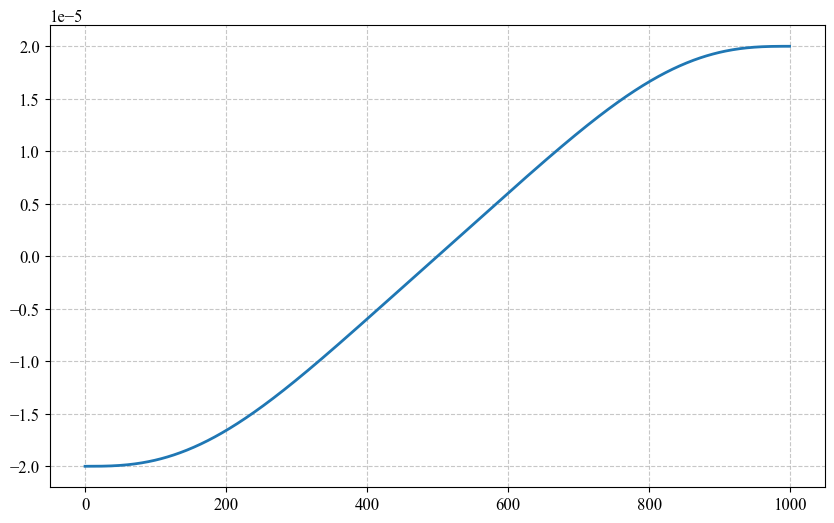

In [26]:
# Minimization 2: Using Bernstein Polynomial
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from numpy import gradient


def calculate_integralsum(x_values, y_values):
    """
    Calculate the integral of y with respect to x using Simpson's rule.

    Parameters:
    x_values (array-like): Array of x values.
    y_values (array-like): Array of y values corresponding to x values.

    Returns:
    float: The calculated integral.
    """
    integral = simps(y_values, x_values)
    return integral

def calculate_integral_array(x_values, y_values):
    """
    Calculate the cumulative integral of y with respect to x, returning an array.

    Parameters:
    x_values (array-like): Array of x values.
    y_values (array-like): Array of y values corresponding to x values.

    Returns:
    array: The cumulative integral array.
    """
    integral_array = cumtrapz(y_values, x_values, initial=0)
    return integral_array

def calculate_derivative_array(x_values, y_values):
    """
    Calculate the derivative of y with respect to x, returning an array.

    Parameters:
    x_values (array-like): Array of x values.
    y_values (array-like): Array of y values corresponding to x values.

    Returns:
    array: The derivative array.
    """
    derivative_array = gradient(y_values, x_values, edge_order=2)
    return derivative_array

def bernstein(x, A, B):
    return A * x * (1 - x) ** B

def scaledistance(xrange, velocitycurve, D):    
    # Initial guess for A and scaling to fit the constraint
    A_optimal = D / calculate_integralsum(xrange, velocitycurve)
    
    return A_optimal

def calculate_curve_and_symmetrize(x_range, A, B):
    y_values = bernstein(x_range, A, B)
    y_neg_flipped = -np.flip(y_values)
    y_combined = np.concatenate([y_values, y_neg_flipped])
    x_combined = np.linspace(0, 2 * len(y_values) / len(x_range) * (x_range[-1] - x_range[0]), len(y_combined))
    return x_combined, y_combined

def calculate_derivatives_and_integrals(y_values, x_values, n, m):
    derivatives = []
    integrals = []
    yintcopy = y_values + 0
    for i in range(1, n + 1):
        deriv = calculate_derivative_array(x_values, y_values)
        derivatives.append(deriv)
        y_values = deriv
    
    for i in range(1, m + 1):
        integ = calculate_integral_array(x_values, yintcopy)
        integrals.append(integ)
        yintcopy = integ
    
    return derivatives, integrals

def plot_curves_separately(x_values, y_values, derivatives, integrals, n, m):
    fig, axes = plt.subplots(n + m + 1, 1, figsize=(10, 6 + 3*(n + m)), sharex=True)
    
    axes[0].plot(x_values, y_values, color='blue')
    axes[0].set_ylabel("Acceleration (m/s^2)")
    axes[0].set_title("Original Curve (Acceleration)")
    axes[0].grid(True)
    
    for i, deriv in enumerate(derivatives, 1):
        ylabel = f"{i}th Deriv"
        axes[i].plot(x_values, deriv, linestyle='--')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(f"{i}th Derivative")
        axes[i].grid(True)
    
    for i, integ in enumerate(integrals, 1):
        ylabel = f"{i}th Integ"
        axes[n + i].plot(x_values, integ, linestyle='-.')
        axes[n + i].set_ylabel(ylabel)
        axes[n + i].set_title(f"{i}th Integral")
        axes[n + i].grid(True)
        
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


def main(n=1, m=1, B=2, T=100e-6, D=30e-6):
    x_range = np.linspace(0, T/2, 500)
    x_rangefull = np.linspace(0,T,500*2)
    x_valuesfake, y_values = calculate_curve_and_symmetrize(x_range / (T/2), 1, B)
    y1_values = calculate_integral_array(x_rangefull, y_values)

    Ascaled = scaledistance(x_rangefull, y1_values, D)
    x_valuesfake, y_valuesscaled = calculate_curve_and_symmetrize(x_range / (T/2), Ascaled, B)

    derivatives, integrals = calculate_derivatives_and_integrals(y_valuesscaled, x_rangefull, n, m)
    # plot_curves_separately(x_rangefull, y_valuesscaled, derivatives, integrals, n, m)
    return integrals[-1] + startlocation
# Example usage:
bernsteinramp = main(n=1, m=2, B=3, T=100e-6, D=endlocation - startlocation)
plt.plot(bernsteinramp)
plt.show()

In [27]:
AWGtime = np.linspace(0, movementtime, 1000)

AWGbernstein = initguess_waveform(AWGwaveform, bernsteinramp, AWGtime, globalvariables)
AWGbernstein_cosine = cosinephaseresponse(AWGbernstein)
AWGbernstein_exponential = exponentialphaseresponse(AWGbernstein)

In [28]:
resultsout, movementframes, forceframes = analyze_waveformsurvival(AWGbernstein_exponential, 1e-6, globalvariables, oop_variables, 10, 20)
potentialframes = get_potentialframes_oop(AWGbernstein_exponential, 1e-6, globalvariables, oop_variables, 10, 200)

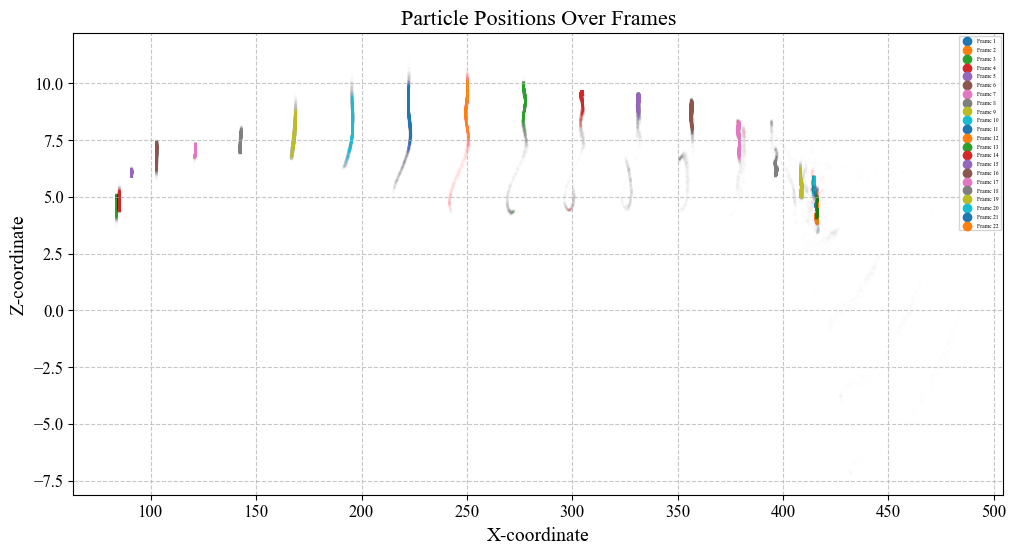

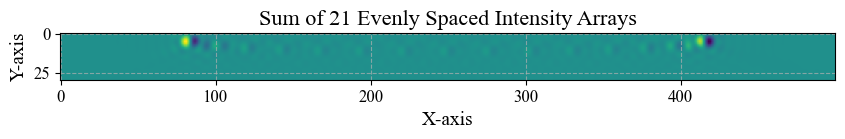

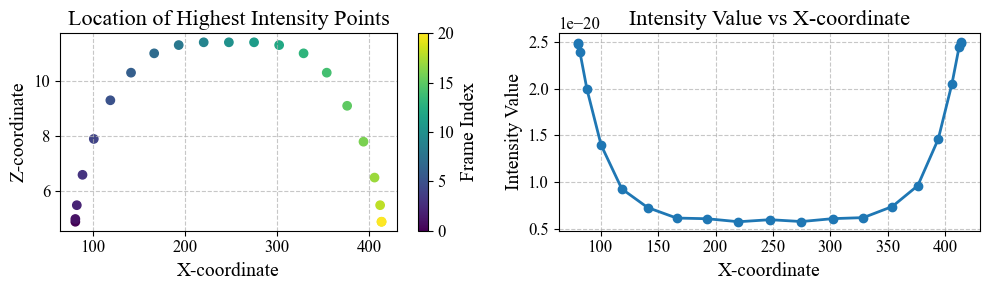

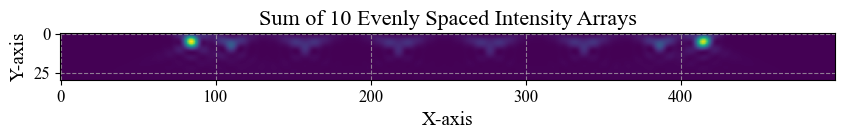

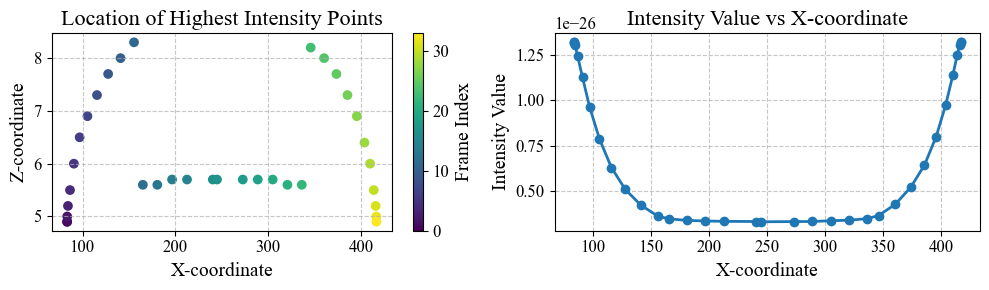

In [29]:
plot_particle_positions_singleshot(movementframes)


sum_and_plot_intensity_arrays(forceframes[:,0], len(forceframes))
highest_points = extract_highest_intensity_points(forceframes[:,0].get(), len(forceframes))
plot_highest_intensity_points(highest_points)

sum_and_plot_intensity_arrays(potentialframes[:], 10)
highest_points = extract_highest_intensity_points(potentialframes[:].get(), 30)
plot_highest_intensity_points(highest_points)



In [30]:
resultsoutx, movementframesx, forceframesx = analyze_waveformsurvival(AWGinitguessexponential, 1e-6, globalvariables, oop_variables, 10, 20)
# resultsoutx, movementframesx, forceframesx = analyze_waveformsurvival(optwaveformout, 1e-6, globalvariables, oop_variables, 10, 10)
potentialframesx = get_potentialframes_oop(AWGinitguessexponential, 1e-6, globalvariables, oop_variables, 10, 200)


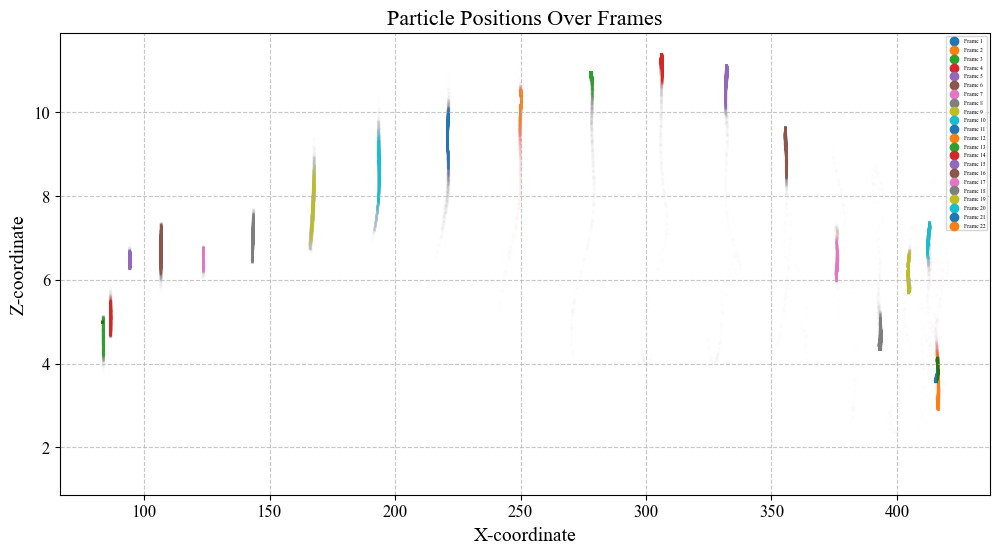

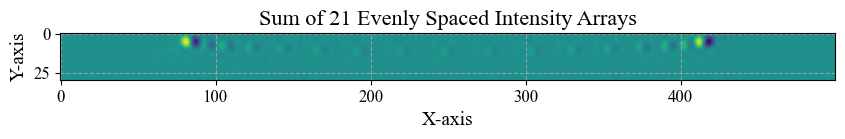

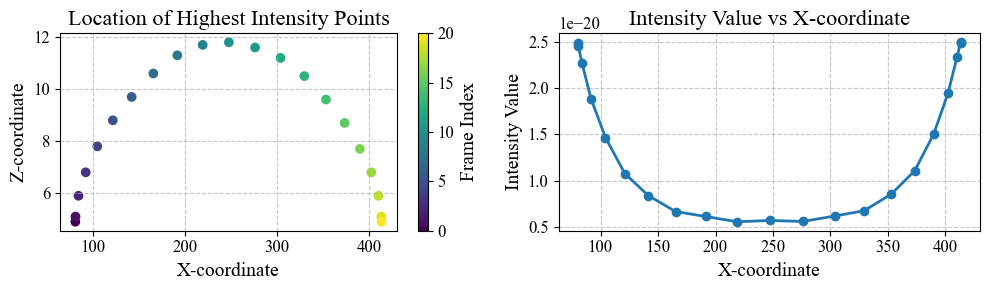

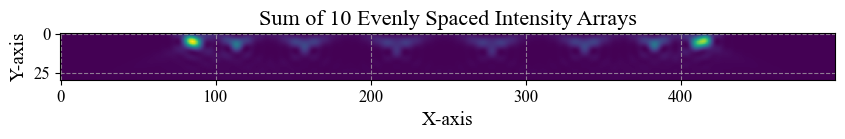

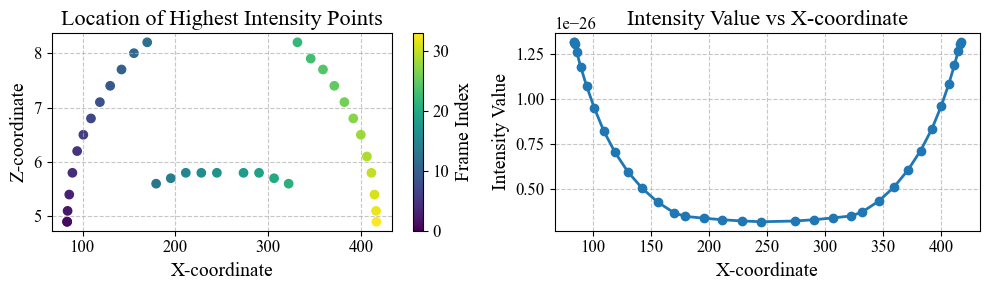

In [31]:
plot_particle_positions_singleshot(movementframesx)

sum_and_plot_intensity_arrays(forceframesx[:,0], len(forceframesx))
highest_points = extract_highest_intensity_points(forceframesx[:,0].get(), len(forceframesx))
plot_highest_intensity_points(highest_points)

sum_and_plot_intensity_arrays(potentialframesx[:], 10)
highest_points = extract_highest_intensity_points(potentialframesx[:].get(), 30)
plot_highest_intensity_points(highest_points)



In [ ]:

resultsout, movementframes, forceframes = analyze_waveformsurvival(AWGlegendreguess_exponential, 1e-6, globalvariables, oop_variables, 10, 20)
potentialframes = get_potentialframes_oop(AWGlegendreguess_exponential, 1e-6, globalvariables, oop_variables, 10, 200)


In [ ]:
plot_particle_positions_singleshot(movementframes)


sum_and_plot_intensity_arrays(forceframes[:,0], len(forceframes))
highest_points = extract_highest_intensity_points(forceframes[:,0].get(), len(forceframes))
plot_highest_intensity_points(highest_points)

sum_and_plot_intensity_arrays(potentialframes[:], 10)
highest_points = extract_highest_intensity_points(potentialframes[:].get(), 30)
plot_highest_intensity_points(highest_points)



In [ ]:
resultsoutx, movementframesx, forceframesx = analyze_waveformsurvival(AWGinitguessexponential, 1e-6, globalvariables, oop_variables, 10, 20)
# resultsoutx, movementframesx, forceframesx = analyze_waveformsurvival(optwaveformout, 1e-6, globalvariables, oop_variables, 10, 10)
potentialframesx = get_potentialframes_oop(AWGinitguessexponential, 1e-6, globalvariables, oop_variables, 10, 200)


In [ ]:
plot_particle_positions_singleshot(movementframesx)

sum_and_plot_intensity_arrays(forceframesx[:,0], len(forceframesx))
highest_points = extract_highest_intensity_points(forceframesx[:,0].get(), len(forceframesx))
plot_highest_intensity_points(highest_points)

sum_and_plot_intensity_arrays(potentialframesx[:], 10)
highest_points = extract_highest_intensity_points(potentialframesx[:].get(), 30)
plot_highest_intensity_points(highest_points)



In [ ]:
# plot_particle_positions(movementframes[0][0][0])
plot_particle_positions_singleshot(movementframes)
plot_particle_positions_singleshot(movementframesx)


sum_and_plot_intensity_arrays(forceframes[:,0], len(forceframes))
sum_and_plot_intensity_arrays(forceframesx[:,0], len(forceframesx))


highest_points = extract_highest_intensity_points(forceframes[:,0].get(), len(forceframes))
lowest_points = extract_lowest_intensity_points(forceframes[:,0].get(), len(forceframes))

highest_pointsx = extract_highest_intensity_points(forceframesx[:,0].get(), len(forceframesx))
lowest_pointsx = extract_lowest_intensity_points(forceframesx[:,0].get(), len(forceframesx))

# Example usage:
plot_highest_intensity_points(highest_points)
plot_highest_intensity_points(lowest_points)

plot_highest_intensity_points(highest_pointsx)
plot_highest_intensity_points(lowest_pointsx)

In [ ]:
plt.subplot(4, 1, 1)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')


# plt.subplot(4, 1, 2)
# plt.plot(time* 10**6, optimized_velocity* 10**6)
# plt.title('Velocity')
# plt.xlabel('Time (microseconds)')
# plt.ylabel('Velocity (microns/microseconds)')
# One micron corresponds to 0.1133786848072586 MHz

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity * 10**6* 0.1133786e9 )
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (m/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()

In [ ]:
movetimes = np.arange(170,200,5)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# readout1, movementframes1 = analyze_fixeddistance_nonoptimized_oop_2D(movetimes, movetemperatures, oop_variables, "Exponential", "Not Ideal", "SinSq", 30, globalvariables)
readout2 = analyze_fixeddistance_nonoptimized(movetimes, movetemperatures, "Exponential", "Not Ideal", "SinSq", 30, globalvariables)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout1)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout1)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout2)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout2)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout2)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout2)

In [ ]:
plots_fixeddistance(movetimes, movetemperatures, readout)

In [ ]:
numzframes, zstart, frame_zspacing, frame_size, frameheight_real = oop_variables

frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame
# testout = retrieve_oop_potentials(AWGinitguessexponential, 20, focallength-5e-6, frame_zspacing,
#                                   49, frame_size, globalvariables, 10)

testout2 = retrieve_oop_forces(AWGinitguessexponential, numzframes, zstart, frame_zspacing, frameheight_real, frame_size, globalvariables, 100)

initdistribution = initdistribution_MaxwellBoltzmann3D(1000, 1e-8, 1e-8, zstart, frame_zspacing, frame_size, globalvariables)
p_out, dp_out, ddp_out = montecarlo_oop_2D(testout2, initdistribution, atommass, frame_size, frame_zspacing, globalvariables)

frame_xspacing = (frame_size[0] * 2 + cp.abs(startlocation - endlocation)) / numpix_frame # in units of meters / FRAME pixel
finalposition_x = (frame_size[0]  + cp.abs(startlocation - endlocation))  / frame_xspacing # In units of FRAME pixels
finalposition_z = (focallength - zstart) / frame_zspacing
finalposition = cp.array([finalposition_x, finalposition_z])

calibration_potential = snapshots_oop_potential(AWGinitguessexponential[-numpix_frame:], 1, numzframes, zstart, frame_zspacing, 
                                                frameheight_real, frame_size, globalvariables)
tweezerwidths = fit_gaussian_2d(calibration_potential)

percentagelive = analyze_survivalprobability_oop_2D(p_out, finalposition, tweezerwidths, globalvariables)

In [ ]:
C = focallength**2 * wavelength / (2*np.pi * soundvelocity**2) * 2*np.pi
z = C * micronstoMHz(expanded_velocity, globalvariables)
w0 = wavelength * focallength / (np.pi * numpix_frame * pixelsize_real) *(4)
z_R = np.pi * w0**2 / wavelength

forcecalibrate = retrieve_oop_forces(AWGinitguessexponential[0:500], numzframes, zstart, frame_zspacing, frameheight_real, frame_size, 
                                     globalvariables)
ax_0 = tonumpy(cp.max(forcecalibrate[0,0]) / atommass)
I0 = ax_0 / (2*np.exp(-1/2) / atommass / w0)
ax_t = 2*np.exp(-1/2) / w0 * (z_R**2 / (z_R**2 + z**2)) * I0 / atommass 
az_t = 9 / (8 * np.sqrt(3) * atommass * z_R) * (z_R**2 / (z_R**2 + z**2)) * I0

poly = Legendre(result_random.x)
    
# Calculate position, velocity, and acceleration
timestep = movementtime  / (arbend - arbstart) # seconds / pixel
position = poly(time) # in units of microns
velocity = poly.deriv(1)(time) # in units of microns / pixel
acceleration = poly.deriv(2)(time) # in units of microns / pixel^2
jerk = poly.deriv(3)(time) # in units of microns/pixel^3

x = position * 1e-6 # in units of meters
dx = velocity * 1e-6 / timestep # in units of meters / s
ddx =  acceleration * 1e-6 / timestep**2 # in units of meters / s^2
dddx =  acceleration * 1e-6 / timestep**3 # in units of meters / s^3


microntoMHZfactor = micronstoMHz(dx[0], globalvariables) / dx[0]
z = C * microntoMHZfactor * dx # now in units of meters
dz = C * microntoMHZfactor * ddx # now in units of meters / s
ddz = C * microntoMHZfactor * dddx # now in units of meters / s^2

ax_t = 2*np.exp(-1/2) * I0/ (w0 * atommass) * (z_R**2 / (z_R**2 + (z)**2)) # now in units of meters / s^2
az_t = 9* I0 / (8 * np.sqrt(3) * atommass * z_R) * (z_R**2 / (z_R**2 + (z) **2)) # now in units of meters / s^2

safetyfactor = 10
ax_t = ax_t * safetyfactor
az_t = az_t * safetyfactor

normalizationfactor_x = np.max(np.abs(ddx)) / np.max(ax_t) 
normalizationfactor_z = np.max(np.abs(ddz)) / np.max(az_t) 
n_ax_t = ax_t / np.max(np.abs(ax_t))
n_ddx = ddx / np.max(np.abs(ddx))
n_az_t = az_t / np.max(np.abs(az_t))
n_ddz = ddz / np.max(np.abs(ddz))
plt.plot(n_az_t)
plt.show()
plt.plot(n_ddz)
plt.show()